# 네이버 영화리뷰 감성분석

## 1.데이터 준비와 확인

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import re
import matplotlib.pyplot as plt

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

### nsmc 데이터셋의 텍스트를 가공하여 data_loader를 만들기.  
1)데이터의 중복 제거  
2)NaN 결측치 제거  
3)한국어 토크나이저로 토큰화  
4)불용어(Stopwords) 제거  
5)사전word_to_index 구성  
6)텍스트 스트링을 사전 인덱스 스트링으로 변환  
7)X_train, y_train, X_test, y_test, word_to_index 리턴  

In [2]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

기능을 수행하는 함수들을 정의

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index): 
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3 모델 구성을 위한 데이터 분석 및 가공

1)데이터셋 내 문장 길이 분포  
2)적절한 최대 문장 길이 지정  
3)keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가  

문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 주기 때문에,   
적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인할 것.

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


적절한 최대 문장 길이는 41로 지정한다.

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가할때,  
padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라  
RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다   
결과적으로 'pre'가 훨씬 유리한데 그 이유는  
입력데이터가 순차적으로 처리 되므로, 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이기 때문이다.

In [7]:
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train_post.shape)

(146182, 41)


In [8]:
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 41)


## 4. 모델 구성 및 validation set 구성

### 모델 생성

### a. RNN 모델 (Recurrent Neural Network)

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 8. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### b. CNN 모델

1-D Convolution Neural Network(1-D CNN)를 사용할 수 있음  
이미지는 시퀀스 데이터가 아니라서,이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용  
1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서  
7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용  
RNN 못지않은 효율  
CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점

In [10]:
vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### c. GlobalMaxPooling1D() 레이어

레이어 하나만 사용하는 방법  
전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

In [11]:
# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수 

model_glob = tf.keras.Sequential()
model_glob.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_glob.add(tf.keras.layers.GlobalMaxPooling1D())
model_glob.add(tf.keras.layers.Dense(8, activation='relu'))
model_glob.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .

model_glob.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### validation set 구성

In [12]:
# 훈련용 데이터셋 146182건 중 10000건을 분리하여 검증셋(validation set)으로 사용
X_val = X_train_pre[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train_pre[10000:]  
partial_y_train = y_train[10000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)
(136182, 41)
(136182,)


## 5. 모델 훈련 및 그래프

### a-1 RNN 모델 훈련

In [13]:
# 모델 학습
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 5s 7ms/step - loss: 0.4940 - accuracy: 0.7843 - val_loss: 0.3602 - val_accuracy: 0.8444
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3393 - accuracy: 0.8574 - val_loss: 0.3391 - val_accuracy: 0.8528
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3157 - accuracy: 0.8678 - val_loss: 0.3384 - val_accuracy: 0.8521
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3032 - accuracy: 0.8734 - val_loss: 0.3349 - val_accuracy: 0.8537
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2933 - accuracy: 0.8783 - val_loss: 0.3351 - val_accuracy: 0.8542
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2829 - accuracy: 0.8838 - val_loss: 0.3412 - val_accuracy: 0.8526
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2742 - accuracy: 0.8875 - val_loss: 0.3447 - val_accuracy: 0.8531
Epoch 

### a-2 RNN 모델  Loss, Accuracy  그래프 시각화 

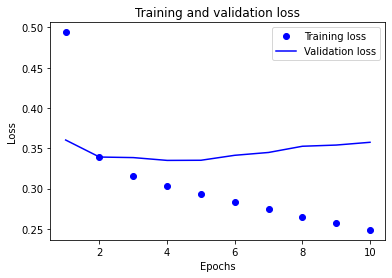

In [14]:
history_rnn_dict = history_rnn.history

# Training and validation loss 그래프 그리기
acc = history_rnn_dict['accuracy']
val_acc = history_rnn_dict['val_accuracy']
loss = history_rnn_dict['loss']
val_loss = history_rnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

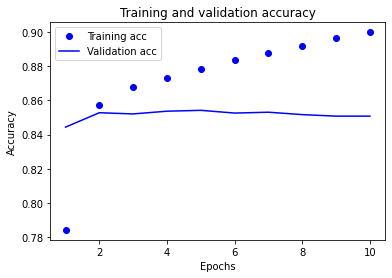

In [15]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### a-3 RNN 모델의 test set 으로 평가

In [16]:
results = model_rnn.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3700 - accuracy: 0.8461
[0.3700120747089386, 0.8461460471153259]


### b-1 CNN 모델 훈련 

In [17]:
# 모델 학습
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2397 - accuracy: 0.9040 - val_loss: 0.3674 - val_accuracy: 0.8510
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2320 - accuracy: 0.9072 - val_loss: 0.3718 - val_accuracy: 0.8497
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2251 - accuracy: 0.9099 - val_loss: 0.3984 - val_accuracy: 0.8497
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2166 - accuracy: 0.9137 - val_loss: 0.4078 - val_accuracy: 0.8501
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2090 - accuracy: 0.9174 - val_loss: 0.4130 - val_accuracy: 0.8496
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2013 - accuracy: 0.9205 - val_loss: 0.4279 - val_accuracy: 0.8470
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1960 - accuracy: 0.9223 - val_loss: 0.4443 - val_accuracy: 0.8469
Epoch 

### b-2 CNN 모델 Loss, Accuracy 그래프 시각화

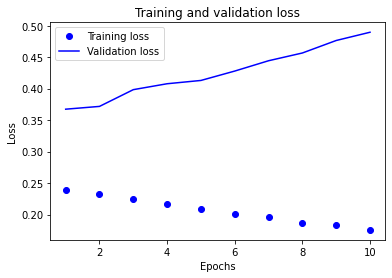

In [18]:
history_cnn_dict = history_cnn.history

# Training and validation loss 그래프 그리기
acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

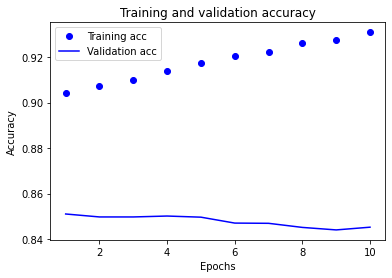

In [19]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### b-3 CNN 모델의 test set 으로 평가

In [20]:
results = model_cnn.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6932 - accuracy: 0.5027
[0.6932086944580078, 0.5026547312736511]


### c-1 GlobalMaxPooling1D() 레이어 모델 훈련 

In [21]:
# 모델 학습
model_glob.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_glob = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 1s 6ms/step - loss: 0.1686 - accuracy: 0.9342 - val_loss: 0.4967 - val_accuracy: 0.8390
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1637 - accuracy: 0.9365 - val_loss: 0.5346 - val_accuracy: 0.8401
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1575 - accuracy: 0.9391 - val_loss: 0.5559 - val_accuracy: 0.8399
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1528 - accuracy: 0.9410 - val_loss: 0.5547 - val_accuracy: 0.8413
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1492 - accuracy: 0.9429 - val_loss: 0.5656 - val_accuracy: 0.8399
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1449 - accuracy: 0.9444 - val_loss: 0.5928 - val_accuracy: 0.8391
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1386 - accuracy: 0.9470 - val_loss: 0.6140 - val_accuracy: 0.8363
Epoch 

### c-2 GlobalMaxPooling1D() 레이어 모델 Loss, Accuracy 그래프 시각화

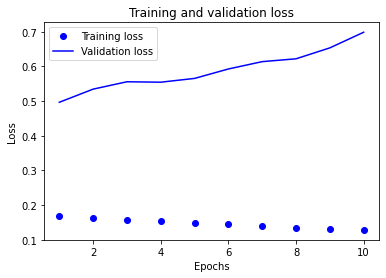

In [22]:
history_glob_dict = history_glob.history

# Training and validation loss 그래프 그리기
acc = history_glob_dict['accuracy']
val_acc = history_glob_dict['val_accuracy']
loss = history_glob_dict['loss']
val_loss = history_glob_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

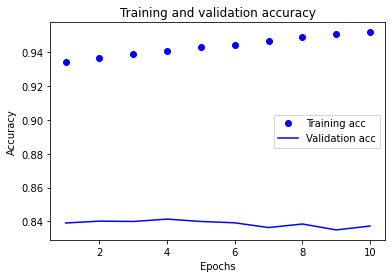

In [23]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### c-3 GlobalMaxPooling1D() 레이어 모델의 test set 으로 평가 

In [24]:
results = model_glob.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6931 - accuracy: 0.4996
[0.6931010484695435, 0.499582976102829]


### 정확도 비교  
RNN : 0.8453  
CNN :  0.4976  
GlobalMaxPooling1D() 레이어 :  0.5051  
RNN 모델의 정확도가 가장 높게 나왔다.

## 6. 학습된 Embedding 레이어 분석

모델 중에 가장 성능이 좋게 나온 RNN 모델로,  
gensim을 사용하여 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지   
확인 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인한다.  

In [25]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('깊', 0.9619878530502319),
 ('경이', 0.9505525827407837),
 ('먹먹', 0.9500730633735657),
 ('재미있', 0.9496873617172241),
 ('재', 0.9458176493644714),
 ('괜찮', 0.9449944496154785),
 ('울리', 0.9447662234306335),
 ('귀여운', 0.9347087144851685),
 ('기도', 0.9343037009239197),
 ('돌아보', 0.9324631690979004)]

In [28]:
word_vectors.similar_by_word("운명")

[('환상', 0.9547414779663086),
 ('퍼펙트', 0.9514039754867554),
 ('오래', 0.9490424394607544),
 ('답니다', 0.9457382559776306),
 ('다시금', 0.9428828358650208),
 ('틀린', 0.9408677816390991),
 ('젊', 0.9373092651367188),
 ('잠수함', 0.9372954964637756),
 ('뭉클', 0.9372777938842773),
 ('음미', 0.9365115165710449)]

In [29]:
word_vectors.similar_by_word("졸림")

[('오글오글', 0.978541374206543),
 ('지겨워', 0.9777795076370239),
 ('장난질', 0.9766854047775269),
 ('퓨전', 0.9756454229354858),
 ('미라', 0.9756125211715698),
 ('고갈', 0.9753183722496033),
 ('와요', 0.9747272729873657),
 ('뒷모습', 0.9730966091156006),
 ('둠', 0.9720144271850586),
 ('토나', 0.9719832539558411)]

위에서 다룬 정도의 훈련 데이터로는 워드 벡터를 정교하게 학습시키기 어렵다

## 7. 한국어 Word2Vec 임베딩 활용하여 성능 개선

Pre-trained word vectors of 30+ languages 에서 한국어 Word2Vec 데이터를 불러옴  
오류를 막기 위해 gensim 버전을 3.x.x로 낮춤  
pip install --upgrade gensim==3.8.3

In [ ]:
!pip install --upgrade gensim==3.8.3

In [30]:
import gensim
from gensim.models import KeyedVectors
gensim.__version__

'3.8.3'

In [31]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_1202/1005516468.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


(200,)

In [32]:
word2vec.similar_by_word("가족")

/tmp/ipykernel_1202/285623575.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("가족")


[('친지', 0.6574771404266357),
 ('유족', 0.6132265329360962),
 ('부부', 0.5933582782745361),
 ('부모님', 0.5929263234138489),
 ('부모', 0.5834078192710876),
 ('식구', 0.5739837288856506),
 ('친족', 0.5737326741218567),
 ('노인', 0.5734318494796753),
 ('자녀', 0.5686265230178833),
 ('부유층', 0.5621210336685181)]

In [33]:
word2vec.similar_by_word("정의")

/tmp/ipykernel_1202/2203783932.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("정의")


[('해석', 0.5746661424636841),
 ('구분', 0.56290602684021),
 ('명시', 0.5549163222312927),
 ('설명', 0.5451807379722595),
 ('표현', 0.5412321090698242),
 ('구현', 0.5403377413749695),
 ('규정', 0.5310025215148926),
 ('판별', 0.5225785970687866),
 ('추상화', 0.5148452520370483),
 ('인식', 0.5117997527122498)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 제대로 학습된다.  
이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여  
RNN 모델(pre padding) 을 학습시킨다.

### RNN 모델 생성

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1202/4247654489.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1202/4247654489.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [35]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_ko = tf.keras.Sequential()
model_ko.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(tf.keras.layers.MaxPooling1D(5))
model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(tf.keras.layers.GlobalMaxPooling1D())
model_ko.add(tf.keras.layers.Dense(8, activation='relu'))
model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_ko.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### 모델 학습 및 시각화

In [37]:
# 학습의 진행
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_ko = model_ko.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 8ms/step - loss: 0.5394 - accuracy: 0.7131 - val_loss: 0.4186 - val_accuracy: 0.8104
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3735 - accuracy: 0.8356 - val_loss: 0.3613 - val_accuracy: 0.8418
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3218 - accuracy: 0.8630 - val_loss: 0.3487 - val_accuracy: 0.8480
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2898 - accuracy: 0.8797 - val_loss: 0.3435 - val_accuracy: 0.8537
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2644 - accuracy: 0.8926 - val_loss: 0.3477 - val_accuracy: 0.8524
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2439 - accuracy: 0.9023 - val_loss: 0.3600 - val_accuracy: 0.8501
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2248 - accuracy: 0.9121 - val_loss: 0.3739 - val_accuracy: 0.8482
Epoch 

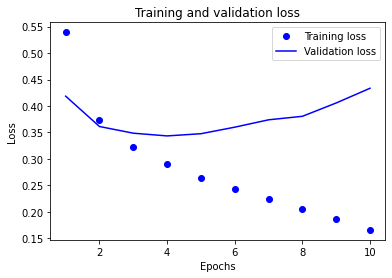

In [38]:
history_ko_dict = history_ko.history

# Training and validation loss 그래프 그리기
acc = history_ko_dict['accuracy']
val_acc = history_ko_dict['val_accuracy']
loss = history_ko_dict['loss']
val_loss = history_ko_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

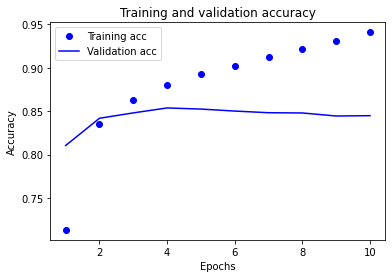

In [39]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델의 test set 으로 평가 

In [40]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4527 - accuracy: 0.8400
[0.45267391204833984, 0.8399820923805237]


### 새로 모델을 생성한 결과 test set 에서의 정확도는 0.8400

## 8. 회고
영화리뷰를 전처리하여 분석하는 과정이 흥미러웠고 배웠던 이론을 실전에 적용하는 과정이 재미있었다.  
영어를 넘어 한글을 적용해보는 경험을 통해 다양한 언어에 적용하는 방법을 배울 수 있었다.  
여러가지 모델을 통해 학습 적용을 해 봄을 통해 다양한 모델에 대해 공부할 수 있었고  
한국어 Word2Vec 임베딩 활용하여 성능 개선의 방법을 배울수 있었다.  
하지만 적용한 결과 RNN에서는 정확도가 0.8453이 나왔지만  
새로 모델을 적용한 결과 정확도가  0.8400로 오히려 줄어드는 결과가 나와서 당황하였다.  
앞으로 원인을 찾고 새로운 개선방법을 공부해 볼 생각이다.  